#  &#x1F4D1; **作业 12: 强化学习**

如果有任何问题, 可以邮件联系我们 [ntu-ml-2022spring-ta@googlegroups.com](ntu-ml-2022spring-ta@googlegroups.com)

In [5]:
# 必要环境配置与包安转
!apt update
!pip uninstall gym -y
!pip install gym==0.25.2
!apt install python-opengl xvfb -y
!pip install swig
!pip install box2d box2d-kengz
!pip install gym[box2d] pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]    
Hit:3 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease0m                       
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1356 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3260 kB]
Fetched 4957 kB in 2s (3043 kB/s)                 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
70 packages can be upgraded. Run 'apt list --upgradable' to see them.
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
  Using cached gym-0.25.2-py3-none-any.whl
Reading

In [6]:
# 加载需要的包
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import typing as typ
from torch.distributions import Categorical
# from tqdm.auto import tqdm
from tqdm import tqdm # 下载notebook 仍能显示
import gym
import random
import os
from rich.console import Console
import warnings

warnings.filterwarnings('ignore')
cs = Console()
v_dispaly = Display(visible=0, size=(1400, 900))
v_dispaly.start()
print("gym.__version__=", gym.__version__)

gym.__version__= 0.25.2


In [7]:
# 设置seed便于复现
NOTEBOOK_SEED = 543

In [8]:
def all_seed(seed=6666, env=None):
    if env is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

# 环境描述

“LunarLander-v2”是为了模拟飞船降落在月球表面时的情况。这项任务是使飞船能够“安全”降落在两面黄旗之间的停机坪上。
> 着陆台始终位于坐标（0,0）处  
> 坐标是状态向量中的前两个数字

![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

`LunarLander-v2`实际上包含`Agent`和`Environment`.   
在本作业中，我们将使用函数`step()` 来控制`Agent`的动作。  
`step()`将返回“环境”给予的观察/状态和奖励. 
- observation / state
- reward
- done (True/ False)
- Other information

`Discrete(4)`意味着`Agent`可以采取四种行动.
- 0 agnet 不做任何动作
- 2 将加速向下
- 1 将加速向左
- 3 将加速向右


接下来，我们将尝试使代理与环境进行交互。在采取任何操作之前，我们建议调用`env.reset()`函数来重置环境。此外，此函数将返回环境的初始状态。    
具体我们可以在`Random Agent` 中查看

关于奖励`reward`
> 着陆台始终位于坐标（0,0）处。坐标是状态向量中的前两个数字。  
> 从屏幕顶部移动到着陆台和零速度的奖励约为100.140分。若着陆器离开着陆台，它将失去回报。  
> 如果着陆器坠毁或休息，则结束，获得额外的-100或+100分。  
> 每个腿部接地触点为+10。主机点火为每帧-0.3分。已解决的是200点。

In [9]:
def gym_env_desc(env_name):
    """
    对环境的简单描述
    """
    env = gym.make(env_name)
    state_shape = env.observation_space.shape
    cs.print("observation_space:\n\t", env.observation_space)
    cs.print("action_space:\n\t", env.action_space)
    try:
        action_shape = env.action_space.n
        action_type = '离散'
        extra=''
    except Exception as e:
        action_shape = env.action_space.shape
        low_ = env.action_space.low[0]  # 连续动作的最小值
        up_ = env.action_space.high[0]  # 连续动作的最大值
        extra=f'<{low_} -> {up_}>'
        action_type = '连续'
    print(f'[ {env_name} ](state: {state_shape},action: {action_shape}({action_type} {extra}))')
    return 

In [10]:
env_name= 'LunarLander-v2'
gym_env_desc(env_name)
env = gym.make(env_name)

observation_space:
         Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

action_space:
         Discrete(4)

[ LunarLander-v2 ](state: (8,),action: 4(离散 ))


# Random Agent
最后，在我们开始训练之前，我们可以看看一个`Random Agent`是否能成功登月。

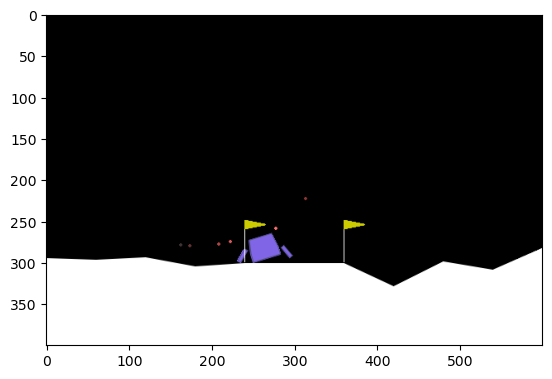

In [8]:
env = gym.make(env_name) # 如果gym.__version__==0.26.2: 只需要 gym.make(env_name, render_mode='rgb_array') 
all_seed(seed=NOTEBOOK_SEED, env=env)
env.reset()

img = plt.imshow(env.render(mode='rgb_array')) # 如果gym.__version__==0.26.2: 只需要 plt.imshow(env.render())
done = False
while not done:
    a = env.action_space.sample()
    n_state, reward, done, _ = env.step(a)
    img.set_data(env.render(mode='rgb_array')) # 如果gym.__version__==0.26.2: 只需要 img.set_data(env.render()) 
    display.display(plt.gcf())
    display.clear_output(wait=True)

# 策略梯度
现在，我们可以建立一个简单的`Policy Network`。网络将返回动作空间概率，再抽样出一个动作

In [11]:
class PolicyGradientNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super(PolicyGradientNet, self).__init__()
        self.q_net = nn.ModuleList([
            nn.ModuleDict({
                'linear': nn.Linear(state_dim, 32),
                'linear_activation': nn.Tanh()
            }),
            nn.ModuleDict({
                'linear': nn.Linear(32, 32),
                'linear_activation': nn.Tanh()
            }),
            nn.ModuleDict({
                'linear': nn.Linear(32, action_dim),
                'linear_activation': nn.Softmax(dim=-1)
            })
        ])
        
    def forward(self, x):
        for layer in self.q_net:
            x = layer['linear_activation'](layer['linear'](x))
        return x

## &#x1F4CC; REINFORCE

\begin{aligned}
      &\rule{110mm}{0.4pt}                                                                 \\
      &\textbf{Algorithm 1}:\text{策略梯度(Policy Gradient)}                                \\
      &\rule{110mm}{0.4pt}                                                                 \\
      &\textbf{function} :\text{REINFORCE}                         \\
      &\hspace{5mm}\text{初始化策略网络参数(Initialize policy parameters)} \ \  \theta \\
      &\hspace{5mm}\textbf{for } \: \text{episode_transition  in} \  [\{s_1, a_1, r_1 \}, \{s_2, a_2, r_2 \}...\{s_n, a_n, r_n\}] \text{~} \pi(\theta) \ \textbf{do}                         \\
      &\hspace{10mm}\textbf{for } t=1 \text{ to T } \textbf{ do}\: \\
      &\hspace{15mm}\text{计算折扣收益} R_t = \sum_{i=t}^{T} \gamma ^{i-t} r_i \\
      &\hspace{15mm}\text{更新策略网络参数} \theta \leftarrow \theta + \alpha \nabla_{\theta} log \pi_{\theta}(a_t|s_t) R_t \\
      &\hspace{15mm}\textbf{end for } \\
      &\hspace{10mm}\textbf{end for } \\
      &\hspace{10mm}\bf{return} \:  \theta                                                 \\
      &\textbf{end function} \\
      &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
 \end{aligned}



In [12]:
from torch.optim.lr_scheduler import StepLR
from typing import List, Dict, AnyStr
from functools import reduce

class REINFORCE():
    def __init__(self, state_dim: int, action_dim: int, lr: float=0.001, gamma: float=0.9, 
                 stepLR_step_size:int = 200,
                 stepLR_gamma:float = 0.1,
                 normalize_reward:bool=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = PolicyGradientNet(state_dim, action_dim)
        self.policy_net.to(self.device)
        self.opt = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.stepLR_step_size = stepLR_step_size
        self.stepLR_gamma = stepLR_gamma
        self.sche = StepLR(self.opt, step_size=self.stepLR_step_size, gamma=self.stepLR_gamma)
        self.gamma = gamma
        self.normalize_reward = normalize_reward
        self.training = True
    
    def train(self):
        self.training = True
        self.policy_net.train()

    def eval(self):
        self.training = False
        self.policy_net.eval()
        
    @torch.no_grad()
    def policy(self, state):
        """
        sample action
        """
        action_prob = self.policy_net(torch.FloatTensor(state).to(self.device))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        return action.detach().cpu().item()

    def batch_update(self, batch_episode: List[Dict[AnyStr, List]]):
        for transition_dict in batch_episode:
            self.update(transition_dict)
        self.sche.step()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
        # 分数 normalize
        if self.normalize_reward:
            reward_list = (np.array(reward_list) - np.mean(reward_list)) / (np.std(reward_list) + 1e-9)
        Rt = 0
        self.opt.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).unsqueeze(0).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action.long()))
            # Rt = \sum_{i=t}^T \gamma ^ {i-t} r_i
            Rt = self.gamma * Rt + reward
            loss = -log_prob * Rt
            loss.backward()
        self.opt.step() 
        
    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        file_path = os.path.join(model_dir, 'policy_net.ckpt')
        torch.save(self.policy_net.state_dict(), file_path)

    def load_model(self, model_dir):
        file_path = os.path.join(model_dir, 'policy_net.ckpt')
        self.policy_net.load_state_dict(torch.load(file_path))


##  &#x2728; 训练 Angent
用策略梯度算法训练Agent

In [13]:
def train_on_policy(
    agent, 
    env, 
    num_batch=450,
    random_batch=2,
    episode_per_batch=3,
    episode_max_step=300,
    save_mdoel_dir='./check_point'
):
    """
    on policy 强化学习算法学习简单函数
    params:
        agent: 智能体
        env: 环境
        random_batch: 前N个batch用random Agent收集数据
        num_batch: 训练多少个batch
        episode_per_batch： 一个batch下多少个episode
        episode_max_step: 每个episode最大步数
        save_mdoel_dir: 模型保存的文件夹
    """
    EPISODE_PER_BATCH = episode_per_batch
    NUM_BATCH = num_batch
    RANDOM_BATCH = random_batch
    MAX_STEP = episode_max_step
    avg_total_rewards, avg_final_rewards, avg_total_steps = [], [], []
    agent.train()
    tq_bar = tqdm(range(RANDOM_BATCH + NUM_BATCH))
    recent_best = -np.inf
    batch_best = -np.inf
    all_rewards = []
    for batch in tq_bar:
        tq_bar.set_description(f"[ {batch+1}/{NUM_BATCH} ]")
        batch_recordes = []
        total_rewards = []
        total_steps = []
        final_rewards = []
        for ep in range(EPISODE_PER_BATCH):
            rec_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            total_reward, total_step = 0, 0
            while True:
                a = agent.policy(state)
                if batch < RANDOM_BATCH:
                    a = env.action_space.sample()

                n_state, reward, done, _ = env.step(a)
                # 收集每一步的信息
                rec_dict['states'].append(state)
                rec_dict['actions'].append(a)
                rec_dict['next_states'].append(n_state)
                rec_dict['rewards'].append(reward)
                rec_dict['dones'].append(done)
                state = n_state
                total_reward += reward
                total_step += 1
                if done or total_step > MAX_STEP:
                    # 一个episode结束后 收集相关信息
                    final_rewards.append(reward)
                    total_steps.append(total_step)
                    total_rewards.append(total_reward)
                    all_rewards.append(total_reward)
                    batch_recordes.append(rec_dict)
                    break

        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        avg_total_step = sum(total_steps) / len(total_steps)
        recent_batch_best = np.mean(all_rewards[-10:])
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
        avg_total_steps.append(avg_total_step)
        # 在进度条后面显示关注的信息
        tq_bar.set_postfix({
            "Total": f"{avg_total_reward: 4.1f}", 
            "Recent": f"{recent_batch_best: 4.1f}", 
            "RecentBest": f"{recent_best: 4.1f}", 
            "Final": f"{avg_final_reward: 4.1f}", 
            "Steps": f"{avg_total_step: 4.1f}"})
        agent.batch_update(batch_recordes)
        if avg_total_reward > batch_best and (batch > 4 + RANDOM_BATCH):
            batch_best = avg_total_reward
            agent.save_model(save_mdoel_dir + "_batchBest")
        if recent_batch_best > recent_best and (batch > 4 + RANDOM_BATCH):
            recent_best = recent_batch_best
            agent.save_model(save_mdoel_dir)
        
    return avg_total_rewards, avg_final_rewards, avg_total_steps

### 用简单环境（`CartPole-v1`）测试

看我们的算法写是否正确

In [12]:
# test sample env
env_name= 'CartPole-v1'
gym_env_desc(env_name)
env = gym.make(env_name)
all_seed(seed=NOTEBOOK_SEED, env=env)
agent = REINFORCE(
    state_dim=env.observation_space.shape[0], 
    action_dim=env.action_space.n, 
    lr=0.01,
    gamma=0.8,
    stepLR_step_size=80
)
avg_total_rewards, avg_final_rewards, avg_total_steps = train_on_policy(
    agent, env, 
    num_batch=160,
    random_batch=2,
    episode_per_batch=5,
    episode_max_step=300,
    save_mdoel_dir='./check_point'
)

observation_space:
         Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 
4.1887903e-01 3.4028235e+38], (4,), float32)

action_space:
         Discrete(2)

[ CartPole-v1 ](state: (4,),action: 2(离散 ))
Set env random_seed = 543


[ 162/160 ]: 100%|██████████| 162/162 [02:34<00:00,  1.05it/s, Total=292.4, Recent=287.1, RecentBest=301.0, Final=1.0, Steps=292.4]


#### 训练结果查看
在训练过程中，我们记录了`avg_total_reward`，它表示更新策略网络训练过程中的平均总奖励。
从理论上讲，如果`Agent`变得更好，则`avg_tal_reward`将增加。

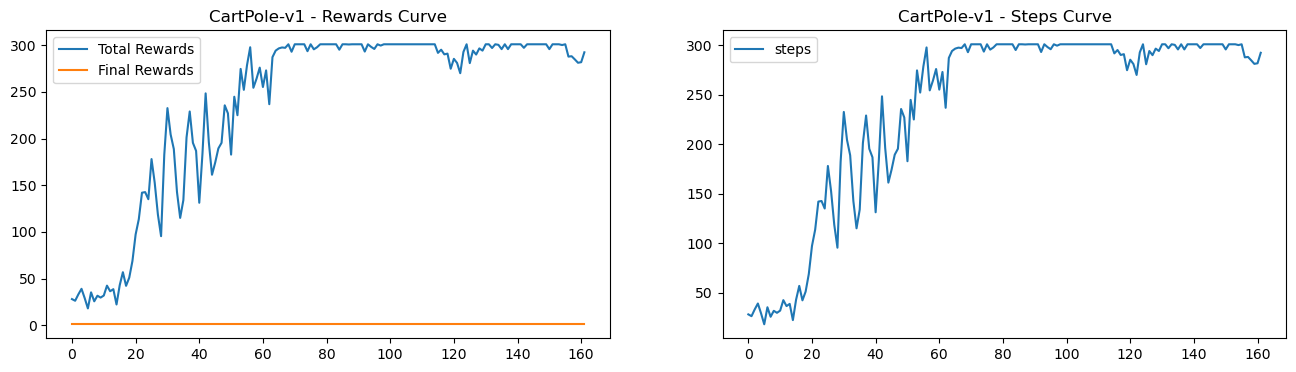

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(avg_total_rewards, label='Total Rewards')
axes[0].plot(avg_final_rewards, label='Final Rewards')
axes[0].set_title(f'{env_name} - Rewards Curve')
axes[0].legend()
axes[1].plot(avg_total_steps, label='steps')
axes[1].set_title(f'{env_name} - Steps Curve')
axes[1].legend()
plt.show()

## &#x2728;  训练`LunarLander-v2`

In [14]:
env_name= 'LunarLander-v2'
gym_env_desc(env_name)
env = gym.make(env_name)
all_seed(seed=NOTEBOOK_SEED, env=env)
agent = REINFORCE(
    state_dim=env.observation_space.shape[0], 
    action_dim=env.action_space.n, 
    lr=0.001,
    gamma=0.99,
    normalize_reward=True,
    stepLR_step_size = 150,
    stepLR_gamma = 0.75
)

avg_total_rewards, avg_final_rewards, avg_total_steps = train_on_policy(
    agent, env, 
    num_batch=800,
    random_batch=3,
    episode_per_batch=3,
    episode_max_step=300, 
    save_mdoel_dir='./check_point_LunarLander_REINFORCE'
)

observation_space:
         Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

action_space:
         Discrete(4)

[ LunarLander-v2 ](state: (8,),action: 4(离散 ))
Set env random_seed = 543


[ 803/800 ]: 100%|██████████| 803/803 [09:59<00:00,  1.34it/s, Total=50.5, Recent=82.0, RecentBest=128.5, Final=-34.6, Steps=265.7]      


### 训练结果查看
在训练过程中，我们记录了`avg_total_reward`，它表示更新策略网络训练过程中的平均总奖励。
从理论上讲，如果`Agent`变得更好，则`avg_tal_reward`将增加。

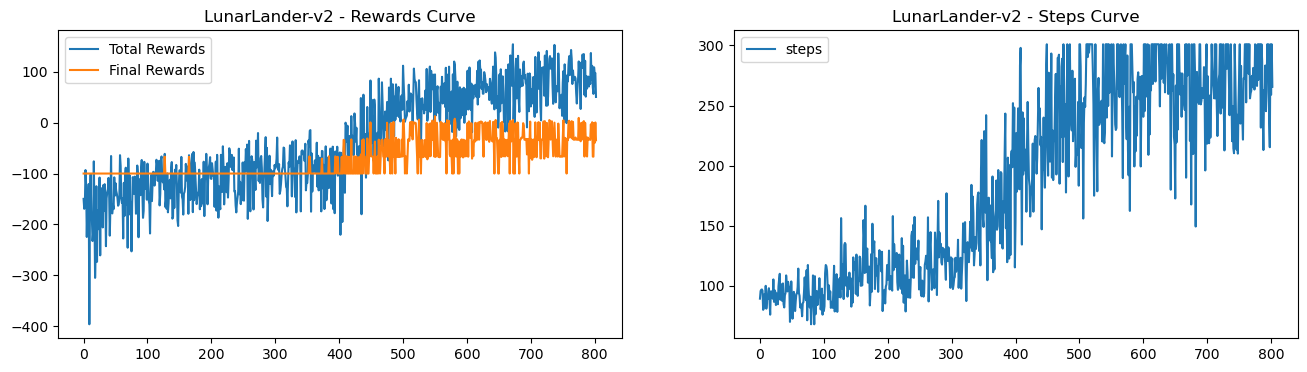

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(avg_total_rewards, label='Total Rewards')
axes[0].plot(avg_final_rewards, label='Final Rewards')
axes[0].set_title(f'{env_name} - Rewards Curve')
axes[0].legend()
axes[1].plot(avg_total_steps, label='steps')
axes[1].set_title(f'{env_name} - Steps Curve')
axes[1].legend()
plt.show()

## &#x2728; Testing
测试结果将是5次测试的平均奖励

In [45]:
def test_agent(agent, env, max_steps=None, plot_flag=True):
    NUM_OF_TEST = 5 # Do not revise this !!!
    test_total_reward = []
    action_list = []
    env_name_ = str(env).rsplit('<', 1)[-1].replace('>', '')
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()
        if plot_flag:
            img = plt.imshow(env.render(mode='rgb_array'))
            plt.title(f'Test {env_name_}\n[ {i+1} / {NUM_OF_TEST} ]')
        total_reward = 0
        print(f"Inintial rewards={total_reward}")
        done = False
        ep_step = 0
        while not done:
            action = agent.policy(state)
            actions.append(action)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            ep_step += 1
            if plot_flag:
                img.set_data(env.render(mode='rgb_array'))
                display.display(plt.gcf())
                display.clear_output(wait=True)
            if max_steps is not None:
                done = max_steps < ep_step

        print(f'[ {i+1}/{NUM_OF_TEST} ] step: {ep_step} reward: {total_reward}')
        test_total_reward.append(total_reward)
        action_list.append(actions) # save the result of testing 
    return test_total_reward, action_list

[ 5/5 ] step: 201
-1283.0784446862065


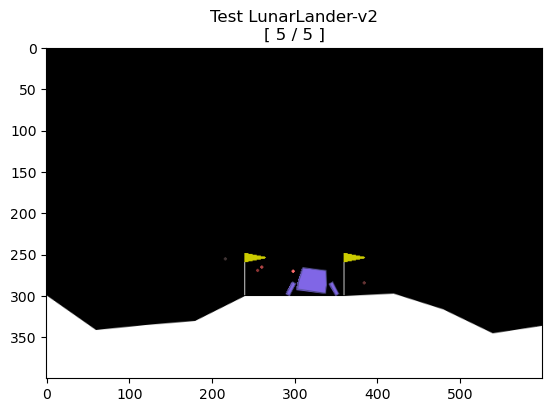

In [17]:
env_name= 'LunarLander-v2'
all_seed(seed=NOTEBOOK_SEED, env=env)
agent.load_model('./check_point_LunarLander_REINFORCE')
agent.eval() 
test_total_reward, action_list = test_agent(agent, env, max_steps=200)

In [20]:
print(test_total_reward)
print(np.mean(test_total_reward))
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

[142.26464450207197, 93.08811839133789, 135.46075436962914, 61.85014410047371, 16.921555313793576]
89.91704333546126
Action list looks like  [[0 2 2 ... 1 2 0]
 [3 0 3 ... 2 2 1]
 [1 2 2 ... 3 3 0]
 [1 0 1 ... 2 1 1]
 [2 3 3 ... 3 2 3]]
Action list's shape looks like  (5, 201)


In [21]:
distribution = {}
for actions in action_list:
    for action in actions:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{0: 91, 2: 525, 1: 202, 3: 187}


保存模型结果

In [22]:
PATH = "Action_List.npy"
np.save(PATH, np.array(action_list)) 

### 这是需要提交的文件！！！ 将测试结果下载到您的设备
# from google.colab import files
# files.download(PATH)

## 服务器(Server)

下面的代码模拟了法官服务器上的环境。可用于测试。

In [23]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
env_name= 'LunarLander-v2'
all_seed(seed=NOTEBOOK_SEED, env=env)

test_total_reward = []
if len(action_list) != 5:
    print("Wrong format of file !!!")
    exit(0)
for idx, actions in enumerate(action_list):
    state = env.reset()
#     img = plt.imshow(env.render(mode='rgb_array'))
#     plt.title(f'Test {env_name}\n[ {idx+1} / 5 ]')
    total_reward = 0
    done = False
    for action in actions:
        state, reward, done, _ = env.step(action)
        total_reward += reward
#         img.set_data(env.render(mode='rgb_array'))
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        if done:
            break
    print(f"Your reward is : %.2f" % total_reward)
    test_total_reward.append(total_reward)

# 最终分数
print(f"Your final reward is : %.2f" % np.mean(test_total_reward))

Set env random_seed = 543
Your reward is : 142.26
Your reward is : 93.09
Your reward is : 135.46
Your reward is : 61.85
Your reward is : 16.92
Your final reward is : 89.92


# &#x1F4CC; Actor-Critic

actor 直接使用 `PolicyGradientNet`


\begin{aligned}
      &\rule{110mm}{0.4pt}                                                                 \\
      &\textbf{Algorithm 2}:\text{Actor-Critic}                   \\
      &\rule{110mm}{0.4pt}                                                                 \\
      &\textbf{function} :\text{REINFORCE with Baseline}                         \\
      &\hspace{5mm}\text{初始化策略网络参数(Initialize policy parameters)} \ \  \theta \\
      &\hspace{5mm}\text{初始化crtic网络参数(Initialize baseline function parameters)} \ \  \phi \\
      &\hspace{5mm}\textbf{for } \: \text{episode_transition  in} \  [\{s_1, a_1, r_1 \}, \{s_2, a_2, r_2 \}...\{s_n, a_n, r_n\}] \text{~} \pi(\theta) \ \textbf{do}                         \\
      &\hspace{10mm}\textbf{for } t=1 \text{ to T } \textbf{ do}\: \\
      &\hspace{15mm}\text{计算折扣收益} R_t = \sum_{i=t}^{T} \gamma ^{i-t} r_i \\
      &\hspace{15mm}\text{估计优势} A_t = R_t - Critic_{\phi}(s_t)     \\
      &\hspace{15mm}\text{计算critic网络损失} loss_{critic} = ||Critic_{\phi}(s_t) - R_t||^2     \\
      &\hspace{15mm}\text{更新critic网络参数} \phi \leftarrow \phi + \alpha_{critic} \nabla_{\phi} loss_{critic} \\
      &\hspace{15mm}\text{更新策略网络参数} \theta \leftarrow \theta + \alpha \nabla_{\theta} log \pi_{\theta}(a_t|s_t) R_t \\
      &\hspace{15mm}\textbf{end for } \\
      &\hspace{10mm}\textbf{end for } \\
      &\hspace{10mm}\bf{return} \:  \theta                                                 \\
      &\textbf{end function} \\
      &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
 \end{aligned}


In [15]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim):
        super(ValueNet, self).__init__()
        self.v_net = nn.ModuleList([
            nn.ModuleDict({
                'linear': nn.Linear(state_dim, 32),
                'linear_activation': nn.ReLU()
            }),
            nn.ModuleDict({
                'linear': nn.Linear(32, 32),
                'linear_activation': nn.ReLU()
            })
        ])
        self.head = nn.Linear(32, 1)

    def forward(self, x):
        for layer in self.v_net:
            x = layer['linear_activation'](layer['linear'](x))
        return self.head(x)

In [16]:
from torch.optim.lr_scheduler import LinearLR

class ActorCritic:
    """
    REINFORCE with Baseline
    """
    def __init__(self, state_dim: int, action_dim: int, actor_lr: float=0.001, critic_lr: float=0.001, gamma: float=0.9, 
                 schedule_kwargs: dict = dict(
                     schedule_func_name='StepLR',
                     stepLR_step_size = 200,
                     stepLR_gamma = 0.1,
                 ),
                 normalize_reward:bool = False):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.actor = PolicyGradientNet(state_dim, action_dim)
        self.critic = ValueNet(state_dim)
        self.actor.to(self.device)
        self.critic.to(self.device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=critic_lr)
        if schedule_kwargs['schedule_func_name'] == "StepLR":
            self.stepLR_step_size = schedule_kwargs['stepLR_step_size']
            self.stepLR_gamma = schedule_kwargs['stepLR_gamma']
            self.actor_sche = StepLR(self.actor_opt, step_size=self.stepLR_step_size, gamma=self.stepLR_gamma)
            self.critic_sche = StepLR(self.critic_opt, step_size=self.stepLR_step_size, gamma=self.stepLR_gamma)
        if schedule_kwargs['schedule_func_name'] == "LinearLR":
            self.end_factor = schedule_kwargs['end_factor']
            self.total_iters = schedule_kwargs['total_iters']
            self.actor_sche = LinearLR(self.actor_opt, start_factor=1, end_factor=self.end_factor, total_iters=self.total_iters)
            self.critic_sche = LinearLR(self.critic_opt, start_factor=1, end_factor=self.end_factor, total_iters=self.total_iters)
        
        self.gamma = gamma
        self.normalize_reward = normalize_reward
        self.training = True
        
    def train(self):
        self.training = True
        self.actor.train()
        self.critic.train()

    def eval(self):
        self.training = False
        self.actor.eval()
        self.critic.eval()
        
    @torch.no_grad()
    def policy(self, state):
        """
        sample action
        """
        action_prob = self.actor(torch.FloatTensor(state).to(self.device))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        return action.detach().cpu().item()

    def batch_update(self, batch_episode: List[Dict[AnyStr, List]]):
        for transition_dict in batch_episode:
            self.update(transition_dict)
        self.actor_sche.step()
        self.critic_sche.step()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
        # 分数 normalize
        if self.normalize_reward:
            reward_list = (np.array(reward_list) - np.mean(reward_list)) / (np.std(reward_list) + 1e-9)
        Rt = 0
        self.actor_opt.zero_grad()
        self.critic_opt.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).unsqueeze(0).to(self.device)
            log_prob = torch.log(self.actor(state).gather(1, action.long()))
            # Rt = \sum_{i=t}^T \gamma ^ {i-t} r_i
            Rt = self.gamma * Rt + reward
            At = Rt - self.critic(state)
            critic_loss = torch.square(-At)
            loss = -log_prob * At.detach()  
            critic_loss.backward() 
            loss.backward()
        self.actor_opt.step() 
        self.critic_opt.step()
    
    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        file_path = os.path.join(model_dir, 'actor.ckpt')
        torch.save(self.actor.state_dict(), file_path)
        file_path = os.path.join(model_dir, 'critic.ckpt')
        torch.save(self.critic.state_dict(), file_path)

    def load_model(self, model_dir):
        file_path = os.path.join(model_dir, 'actor.ckpt')
        self.actor.load_state_dict(torch.load(file_path))
        file_path = os.path.join(model_dir, 'critic.ckpt')
        self.critic.load_state_dict(torch.load(file_path))

##  &#x2728; 训练 Angent
用Actor-critic算法训练Agent

In [12]:
env_name= 'LunarLander-v2'
gym_env_desc(env_name)
env = gym.make(env_name)
all_seed(seed=NOTEBOOK_SEED, env=env)

agent = ActorCritic(
    state_dim=env.observation_space.shape[0], 
    action_dim=env.action_space.n, 
    actor_lr=0.0025,
    critic_lr=0.0025, # 0.0017 -> 164   0.0025->263 rd 113
    gamma=0.99,
    normalize_reward=True,
#     schedule_kwargs=dict(
#          schedule_func_name='StepLR',
#     #     stepLR_step_size = 150,  # lr=0.001 episode_max_step=300
#     #     stepLR_gamma = 0.8  # StepLR | Your final reward is : 142.25
#         stepLR_step_size = 120, #  lr=0.001 episode_max_step=300
#         stepLR_gamma = 0.85 # StepLR | Your final reward is : 150.42     Recent=105.5, RecentBest=170.4, Final=-0.1, Steps=301.0]  
#      )
    schedule_kwargs=dict(
        schedule_func_name='LinearLR', 
#         end_factor = 0.1,
#         total_iters = 1000  # Your final reward is : 152.00
        end_factor = 0.1,
        total_iters = 1000
     )
)
avg_total_rewards, avg_final_rewards, avg_total_step = train_on_policy(
    agent, env, 
    num_batch=1200,
    random_batch=3,
    episode_per_batch=3, 
    episode_max_step=300, # 300
    save_mdoel_dir='./check_point_LunarLander-ActorCritic2'
)

observation_space:
         Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

action_space:
         Discrete(4)

[ LunarLander-v2 ](state: (8,),action: 4(离散 ))
Set env random_seed = 543


[ 1203/1200 ]: 100%|██████████| 1203/1203 [24:33<00:00,  1.23s/it, Total=175.9, Recent=226.4, RecentBest=263.3, Final=33.4, Steps=281.3] 


### 训练结果查看

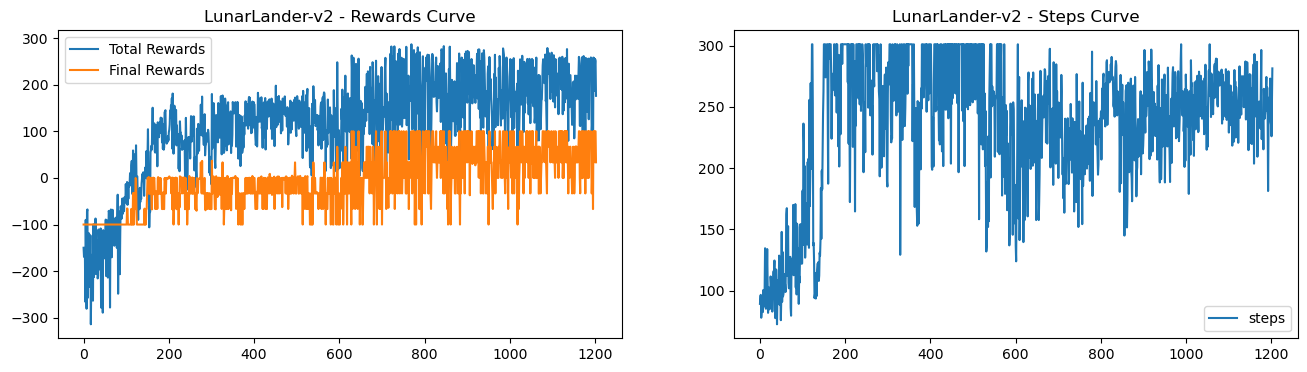

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(avg_total_rewards, label='Total Rewards')
axes[0].plot(avg_final_rewards, label='Final Rewards')
axes[0].set_title(f'{env_name} - Rewards Curve')
axes[0].legend()
axes[1].plot(avg_total_step, label='steps')
axes[1].set_title(f'{env_name} - Steps Curve')
axes[1].legend()
plt.show()

## &#x2728; Testing
测试结果将是5次测试的平均奖励

[ 5/5 ] step: 301
165.07581201793346
[6873.145001689872, 5151.680357221657, 105.92392417548157, 63.27319724993232, 165.07581201793346]
2471.8196584709754


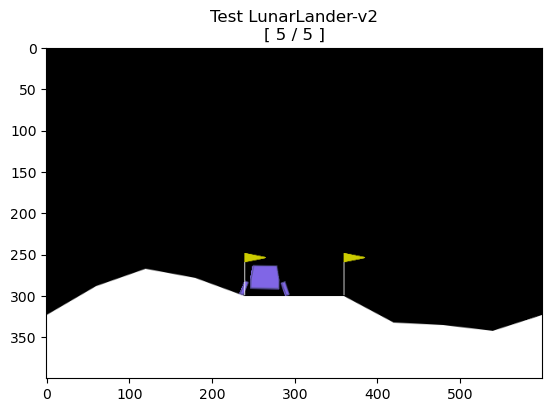

In [34]:
agent = ActorCritic(
    state_dim=env.observation_space.shape[0], 
    action_dim=env.action_space.n, 
    actor_lr=0.0025,
    critic_lr=0.0025,
    gamma=0.99,
    normalize_reward=True,
    schedule_kwargs=dict(
        schedule_func_name='LinearLR', 
        end_factor = 0.1,
        total_iters = 1000
     )
)

env_name= 'LunarLander-v2'
env = gym.make(env_name)
all_seed(seed=NOTEBOOK_SEED, env=env)
agent.load_model('./check_point_LunarLander-ActorCritic2')
agent.eval()
test_total_reward, action_list = test_agent(agent, env, max_steps=300, plot_flag=True)
print(test_total_reward)
print(np.mean(test_total_reward))

In [46]:
env_name= 'LunarLander-v2'
env = gym.make(env_name)
all_seed(seed=NOTEBOOK_SEED, env=env)
agent.load_model('./check_point_LunarLander-ActorCritic2')
agent.eval()
test_total_reward, action_list = test_agent(agent, env, max_steps=300, plot_flag=False)
print(test_total_reward)
print(np.mean(test_total_reward))

Set env random_seed = 543
Inintial rewards=0
[ 1/5 ] step: 301 reward: 6873.145001689872
Inintial rewards=0
[ 2/5 ] step: 301 reward: 5151.680357221657
Inintial rewards=0
[ 3/5 ] step: 301 reward: 105.92392417548157
Inintial rewards=0
[ 4/5 ] step: 301 reward: 63.27319724993232
Inintial rewards=0
[ 5/5 ] step: 301 reward: 165.07581201793346
[6873.145001689872, 5151.680357221657, 105.92392417548157, 63.27319724993232, 165.07581201793346]
2471.8196584709754


# 参考
以下是一些有用的提示，你可以获得高分。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)

更多强化学习的学习资料推荐
- [《Easy RL强化学习教程》](https://datawhalechina.github.io/easy-rl/)
    - [github](https://github.com/datawhalechina/easy-rl)
- [《动手学强化学习》](https://hrl.boyuai.com/chapter/)

